In [31]:
import numpy as np 
import torch
from torch.utils.data import Dataset,DataLoader,ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2
import random
import sys
import seaborn as sns
from sklearn.utils import shuffle

In [2]:
class Dataset(object):
    def __getitem__(self,index):
        raise NotImplementedError
    
    def __len__(self): 
        raise NotImplementedError
    
    def __add__(self,other):
        return ConcatDataset([self,other]) 

In [37]:
class MRI(Dataset):
    def __init__(self):
        tumor = []
        no_tumor = []
        path = './yes/*.jpg'
        for f in glob.iglob(path):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2], img.shape[0], img.shape[1])) 
            tumor.append(img)
        
        path = './no/*.jpg'
        for f in glob.iglob(path):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))
            no_tumor.append(img)
    
        #Images
        tumor = np.array(tumor, dtype = np.float32)
        no_tumor = np.array(no_tumor, dtype=np.float32)
    
        #Labels
        tumor_labels = np.ones(tumor.shape[0], dtype=np.float32) 
        no_tumor_labels = np.zeros(no_tumor.shape[0], dtype=np.float32) 
    
        #Concatenates
        self.X= np.concatenate((tumor, no_tumor), axis = 0)
        self.y = np.concatenate((tumor_labels, no_tumor_labels))
        
        self.X, self.y = shuffle(self.X,self.y)

       
    def __getitem__(self,index):
        sample = {'image': self.X[index] , 'label':self.y[index]}
        return sample
    
    def __len__(self): 
        return self.X.shape[0] 
    
    def normalize(self):
        self.images = self.X/255.0

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels =6 ,out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5)
        )
        
        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1)
        )
    
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x

In [5]:
mri_dataset = MRI()
mri_dataset.normalize()
model = CNN()

In [6]:
device = torch.device('cpu')
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr = eta)
dataloader = DataLoader(mri_dataset, batch_size = 32, shuffle = True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [7]:
for epoch in range(1,EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        #Define loss function
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
    if (epoch+1) % 10==0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

C:\Users\HP\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 10	Loss: 0.469851
Train Epoch: 20	Loss: 0.398658
Train Epoch: 30	Loss: 0.330910
Train Epoch: 40	Loss: 0.257666
Train Epoch: 50	Loss: 0.192685
Train Epoch: 60	Loss: 0.141161
Train Epoch: 70	Loss: 0.104692
Train Epoch: 80	Loss: 0.079181
Train Epoch: 90	Loss: 0.057977
Train Epoch: 100	Loss: 0.040215
Train Epoch: 110	Loss: 0.029882
Train Epoch: 120	Loss: 0.013175
Train Epoch: 130	Loss: 0.006361
Train Epoch: 140	Loss: 0.002493
Train Epoch: 150	Loss: 0.009782
Train Epoch: 160	Loss: 0.001115
Train Epoch: 170	Loss: 0.000657
Train Epoch: 180	Loss: 0.000423
Train Epoch: 190	Loss: 0.000261
Train Epoch: 200	Loss: 0.000159
Train Epoch: 210	Loss: 0.000115
Train Epoch: 220	Loss: 0.000053
Train Epoch: 230	Loss: 0.000030
Train Epoch: 240	Loss: 0.000019
Train Epoch: 250	Loss: 0.000010
Train Epoch: 260	Loss: 0.000006
Train Epoch: 270	Loss: 0.000004
Train Epoch: 280	Loss: 0.000002
Train Epoch: 290	Loss: 0.000001
Train Epoch: 300	Loss: 0.000001
Train Epoch: 310	Loss: 0.000000
Train Epoch: 320	

In [8]:
FILE = "model.pth"
torch.save(model, FILE)

In [14]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size = 32, shuffle=False)
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(image)
        
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

outputs = np.concatenate(outputs, axis= 0)
y_true = np.concatenate(y_true, axis = 0)

In [15]:
def threshold(scores, threshold=0.50, minimum=0, maximum=1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum 
    return x

In [16]:
accuracy_score(y_true, threshold(outputs))

1.0

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'No_tumor')]

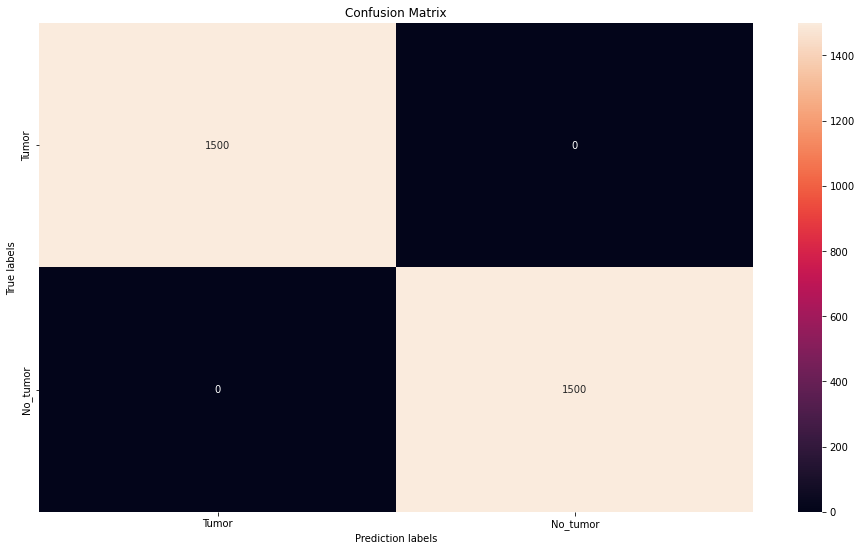

In [26]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax = plt.subplot()
sns.heatmap(cm, annot=True, fmt='g' ,ax = ax);

ax.set_xlabel('Prediction labels'); ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Tumor', 'No_tumor'])
ax.yaxis.set_ticklabels(['Tumor', 'No_tumor'])